# Towards An <strong>E</strong>nd-to-<strong>E</strong>nd Framework for <strong>F</strong>low-<strong>G</strong>uided <strong>V</strong>ideo <strong>I</strong>npainting (CVPR 2022)

In this demo, you can try to inpaint an example video through our framework.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/SeeFit/Video_Inpainting"

/content/drive/MyDrive/SeeFit/Video_Inpainting


# Setup

In [4]:
#@title Setup environment and code (may take some time)

# Install Pytorch
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html 
# Install MMCV
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.5/index.html

# prepare code
import os
CODE_DIR = 'E2FGVI'
# os.makedirs(f'./{CODE_DIR}')
!git clone https://github.com/MCG-NKU/E2FGVI.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.5/index.html
fatal: destination path 'E2FGVI' already exists and is not an empty directory.


In [5]:
#@title Download model with PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

download_with_pydrive = True

class Downloader(object):
    def __init__(self, use_pydrive):
        self.use_pydrive = use_pydrive
        current_directory = os.getcwd()
        self.save_dir = os.path.join(os.path.dirname(current_directory), CODE_DIR, "release_model")
        if not os.path.exists(self.save_dir):        
            os.makedirs(self.save_dir)
        if self.use_pydrive:
            self.authenticate()

    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)

    def download_file(self, file_id, file_name):
        file_dst = f'{self.save_dir}/{file_name}'
        if os.path.exists(file_dst):
            print(f'{file_name} already exists!')
            return
        downloaded = self.drive.CreateFile({'id':file_id})
        downloaded.FetchMetadata(fetch_all=True)
        downloaded.GetContentFile(file_dst)

downloader = Downloader(download_with_pydrive)
path = {"id": "1tNJMTJ2gmWdIXJoHVi5-H504uImUiJW9", "name": "E2FGVI_CVPR22_models.zip"}
downloader.download_file(file_id=path["id"], file_name=path["name"])

os.chdir(downloader.save_dir)
!unzip E2FGVI_CVPR22_models.zip
os.chdir('..')

E2FGVI_CVPR22_models.zip already exists!
Archive:  E2FGVI_CVPR22_models.zip
replace E2FGVI-CVPR22.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace i3d_rgb_imagenet.pt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# Define Utility Functions


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation

import cv2
from PIL import Image
import numpy as np
import importlib
import os
import argparse
from tqdm import tqdm
import torch

# rc('animation', html='jshtml')

from core.utils import to_tensors


# global variables
w, h = 432, 240
ref_length = 10  # ref_step
num_ref = -1
neighbor_stride = 5


# sample reference frames from the whole video 
def get_ref_index(f, neighbor_ids, length):
    ref_index = []
    if num_ref == -1:
        for i in range(0, length, ref_length):
            if i not in neighbor_ids:
                ref_index.append(i)
    else:
        start_idx = max(0, f - ref_length * (num_ref//2))
        end_idx = min(length, f + ref_length * (num_ref//2))
        for i in range(start_idx, end_idx+1, ref_length):
            if i not in neighbor_ids:
                if len(ref_index) > num_ref:
                    break
                ref_index.append(i)
    return ref_index


# read frame-wise masks
def read_mask(mpath):
    masks = []
    mnames = os.listdir(mpath)
    mnames.sort()
    for mp in mnames:
        m = Image.open(os.path.join(mpath, mp))
        m = m.resize((w, h), Image.NEAREST)
        m = np.array(m.convert('L'))
        m = np.array(m > 0).astype(np.uint8)
        m = cv2.dilate(m, cv2.getStructuringElement(
            cv2.MORPH_CROSS, (3, 3)), iterations=4)
        masks.append(Image.fromarray(m*255))
    return masks


#  read frames from video
def read_frame_from_videos(video_path):
    vname = video_path
    frames = []
    lst = os.listdir(vname)
    lst.sort()
    fr_lst = [vname+'/'+name for name in lst]
    for fr in fr_lst:
        image = cv2.imread(fr)
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        frames.append(image.resize((w, h)))
    return frames

# Opencv video to image frames
테스트 데이터셋 만들기

In [ ]:
pwd

'/content/drive/MyDrive/SeeFit/Video_Inpainting'

In [7]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
'''
import cv2
import os
import time

vidcap = cv2.VideoCapture('/E5FGVI/examples/mijin.mp4')

if not vidcap.isOpened():
    print("Could not Open")
    exit(0)

# success,image = vidcap.read()
count = 0

while(vidcap.isOpened()):
    ret, frame = vidcap.read()
    if ret:
        cv2.imshow('frame', frame)
        cv2.imwrite("/content/drive/MyDrive/SeeFit/Video_Inpainting/E5FGVI/examples/mijin/%05d.png" % count, frame)
        print('Read a new fram')
        count += 1  

print("finish! convert video to frame")
'''

Could not Open
finish! convert video to frame


# Inpainting 


In [8]:
# set up models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = importlib.import_module('model.e2fgvi')
model = net.InpaintGenerator().to(device)
ckpt_path = 'release_model/E2FGVI-CVPR22.pth'
data = torch.load(ckpt_path, map_location=device)
model.load_state_dict(data)
print(f'Loading model from: {ckpt_path}')
model.eval()

# prepare dataset
# video_path = 'examples/tennis'
# mask_path = 'examples/tennis_mask'
video_path = 'examples/mijin'
mask_path = 'examples/mijin_mask'
print(f'Loading videos and masks from: {video_path}')
frames = read_frame_from_videos(video_path)
video_length = len(frames)
imgs = to_tensors()(frames).unsqueeze(0) * 2 - 1
frames = [np.array(f).astype(np.uint8) for f in frames]

masks = read_mask(mask_path)
binary_masks = [np.expand_dims((np.array(m) != 0).astype(np.uint8), 2)
                for m in masks]
masks = to_tensors()(masks).unsqueeze(0)
imgs, masks = imgs.to(device), masks.to(device)
comp_frames = [None] * video_length

# completing holes by e2fgvi
print(f'Start test...')
for f in tqdm(range(0, video_length, neighbor_stride)):
    neighbor_ids = [i for i in range(max(0, f-neighbor_stride), min(video_length, f+neighbor_stride+1))]
    ref_ids = get_ref_index(f, neighbor_ids, video_length)
    selected_imgs = imgs[:1, neighbor_ids+ref_ids, :, :, :]
    selected_masks = masks[:1, neighbor_ids+ref_ids, :, :, :]
    with torch.no_grad():
        masked_imgs = selected_imgs*(1-selected_masks)
        pred_img, _ = model(masked_imgs, len(neighbor_ids))

        pred_img = (pred_img + 1) / 2
        pred_img = pred_img.cpu().permute(0, 2, 3, 1).numpy() * 255
        for i in range(len(neighbor_ids)):
            idx = neighbor_ids[i]
            img = np.array(pred_img[i]).astype(
                np.uint8)*binary_masks[idx] + frames[idx] * (1-binary_masks[idx])
            if comp_frames[idx] is None:
                comp_frames[idx] = img
            else:
                comp_frames[idx] = comp_frames[idx].astype(
                    np.float32)*0.5 + img.astype(np.float32)*0.5

/usr/local/lib/python3.7/dist-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '


load pretrained SPyNet...
load checkpoint from http path: https://download.openmmlab.com/mmediting/restorers/basicvsr/spynet_20210409-c6c1bd09.pth


Downloading: "https://download.openmmlab.com/mmediting/restorers/basicvsr/spynet_20210409-c6c1bd09.pth" to /root/.cache/torch/checkpoints/spynet_20210409-c6c1bd09.pth


  0%|          | 0.00/5.50M [00:00<?, ?B/s]

Loading model from: release_model/E2FGVI-CVPR22.pth
Loading videos and masks from: examples/mijin
Start test...


100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


## Show the inpainting video

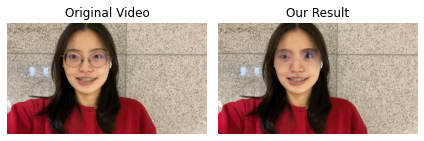

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.axis('off'); ax1.set_title('Original Video')
ax2 = fig.add_subplot(1,2,2)
ax2.axis('off'); ax2.set_title('Our Result')
imdata1 = ax1.imshow(frames[0])
imdata2 = ax2.imshow(comp_frames[0].astype(np.uint8))

def update(idx):
    imdata1.set_data(frames[idx])
    imdata2.set_data(comp_frames[idx].astype(np.uint8))

fig.tight_layout()
anim = animation.FuncAnimation(fig, update, frames=len(frames), interval=50)
from IPython.display import HTML
HTML(anim.to_html5_video())